# Simulation

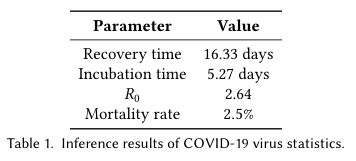

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import pandas as pd
import matplotlib.ticker as mticker
import matplotlib
from matplotlib.pyplot import figure
from matplotlib.ticker import FormatStrFormatter
import numpy as np
from pathlib import Path
Path("./content/sample_data").mkdir(parents=True, exist_ok=True)


## Lockdown only delays the virus spread

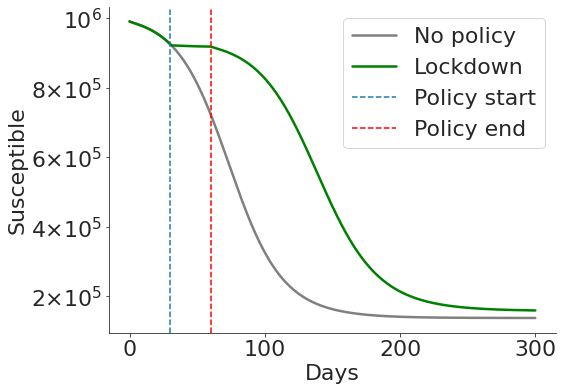

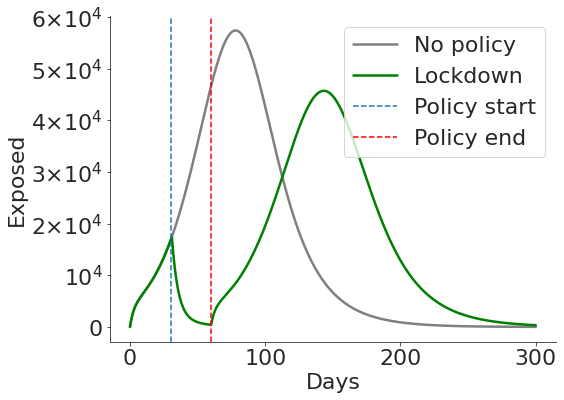

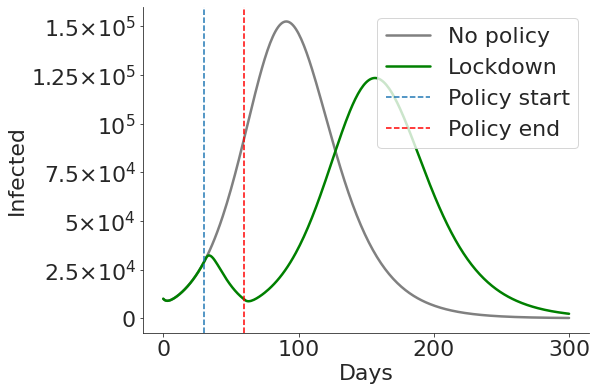

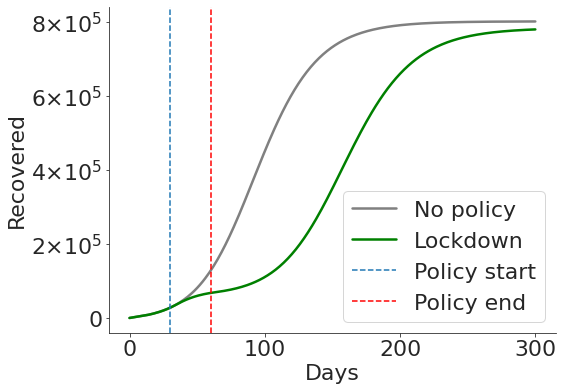

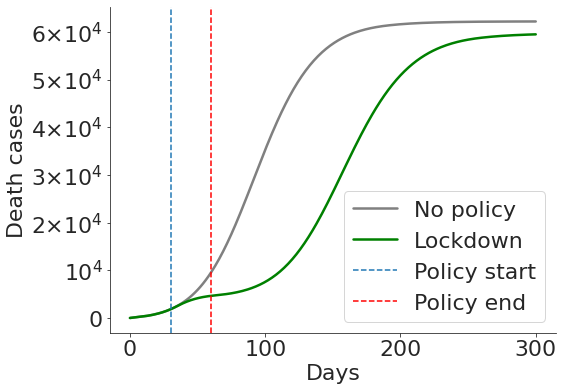

In [2]:
# Set policy efficiencies
test_cap = 0.001
hygiene = 0.30 
distancing = 0.74 
lockdown = 0.96
quarantine = 0.96 

# ASSUMPTIONS:

# Virus parameters
transmission_days = 16.33/2.40 
exposed_days = 5.27 
recovery_days = 16.33 
r0 = 2.64

transmission_rate = (1/ transmission_days)
incubation_rate = (1/  exposed_days)
recovery_rate = (1/ recovery_days)

# Country parameters
hospital_cap = 6/10000
death_rate_with_med = 0.6 # 60% chance to die with ICU treatment
death_rate_without_med = 1 # 100% chance to die without ICU treatment
general_dr = 0.02 # 2% death rate
icu_case_rate = 0.06 # 6% need ICU treatment
ser_case_rate = 0.15 # 15% of serious cases


# Initialize
susceptible0 = 0.99
infected0 = 0.01
exposed0 = 0
recovered0 = 0
population = 1000000
policy_start = 30
policy_end = 60
days = 300


def virus_model(days,policy):

  if policy == "hygiene":
    pol = hygiene
  elif policy == "distancing":
    pol = distancing
  elif policy == "lockdown":
    pol = lockdown
  elif policy == "quarantine":
    pol = quarantine
  elif policy == "None":
    pol = None

  # set values for the first date of the simulation
  susceptible =  susceptible0
  infected = infected0
  exposed = exposed0
  recovered = recovered0
  dead = 0

  # Scale to population size
  susc= [population * susceptible0]
  exp = [population * exposed0]
  inf = [population * infected0]
  rec = [population * recovered0]
  re = [r0]
  d = [0]
  
  for day in range(days):
    if policy_start < day < policy_end  and pol != None:
      transmission_rate = (1/ transmission_days) * (1-pol)
    else:
      transmission_rate = (1/ transmission_days)

    # Simulate flow between compartments
    S2E = susceptible * infected * transmission_rate
    E2I = exposed * incubation_rate
    I2D = general_dr*infected/recovery_days

    # Account different death rates depending on condition
    if (icu_case_rate*infected < hospital_cap):
      I2D += icu_case_rate*infected*death_rate_with_med/recovery_days
    else:
      I2D += hospital_cap*death_rate_with_med/recovery_days + (icu_case_rate*infected - hospital_cap) * death_rate_without_med/recovery_days
    I2R = (1-general_dr)*infected*recovery_rate

    # Update the compartments
    exposed +=  S2E
    susceptible -= S2E
    infected += E2I
    exposed -= E2I
    recovered += I2R
    infected -= I2R
    infected -= I2D
    dead += I2D

    re.append((transmission_rate/ recovery_rate)*susceptible)
    susc.append(population* susceptible)
    exp.append(population* exposed)
    inf.append(population* infected)
    rec.append(population* recovered)
    d.append(population* dead)
  
  return susc, exp, inf, rec, d, re

result_h = virus_model(days,'hygiene')
result_d = virus_model(days,'distancing')
result_l = virus_model(days,'lockdown')
result_q = virus_model(days,'quarantine')
result_0 = virus_model(days,'None')

m = [m for m in range(days+1)]

# Plot the graphs
# Here we plot only lockdown
sns.set_style("ticks")
matplotlib.rcParams['figure.figsize'] = 8, 6
sns.despine()
formatter = mticker.ScalarFormatter(useMathText=True)
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%10e' % x))

plots = ['Susceptible','Exposed', 'Infected','Recovered','Death cases']
abbrev = ['S','E', 'I','R','D']

for num,policy in enumerate(plots):
  plt.plot(m, result_0[num], label="No policy", color ='grey',linewidth=2.5)
  plt.plot(m, result_l[num], label="Lockdown", color ='green',linewidth=2.5)
  plt.axvline(x=policy_start,linestyle='--', linewidth=1.5,  label='Policy start')
  plt.axvline(x=policy_end,linestyle='--', linewidth=1.5, color='red', label='Policy end')
  plt.tick_params(labelsize=22)
  plt.ylabel(policy, fontsize=22)
  plt.xlabel('Days', fontsize=22)
  plt.legend(fontsize=22)
  sns.despine()
  plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(g))
  plt.savefig('./content/sample_data/{}.pdf'.format(abbrev[num]),bbox_inches='tight')
  plt.show()


## Policy Efficacy check


### Find optimal policy

In [3]:
# Set policy efficiencies
test_cap = 0.001
hygiene = 0.30 
distancing = 0.74 
lockdown = 0.96
quarantine = 0.96 

# ASSUMPTIONS:

# Virus parameters
transmission_days = 16.33/2.40 
exposed_days = 5.27 
recovery_days = 16.33 
r0 = 2.64

transmission_rate0 = (1/ transmission_days)
incubation_rate = (1/  exposed_days)
recovery_rate = (1/ recovery_days)

# Country parameters
hospital_cap = 6/10000
death_rate_with_med = 0.6 # 60% chance to die with ICU treatment
death_rate_without_med = 1 # 100% chance to die without ICU treatment
general_dr = 0.02 # 2% death rate
icu_case_rate = 0.06 # 6% need ICU treatment
ser_case_rate = 0.15 # 15% of serious cases

# Initialize
susceptible0 = 0.99
infected0 = 0.01
exposed0 = 0
recovered0 = 0
population = 1000000

# Policy costs: 
lockdown_cost = 0.1 # 10% of yearly GDP
quarantine_cost = 0.05 # 5% of  yearly GDP
mask_cost = 0.002 # 2$
distancing_cost = 0.05 # 5% of yearly GDP

def evaluate(inf, rec, d, policy, cont_tracing):
  ''' Calculate penalty points '''
  dd_point = -7000 # death
  inf_point = -0.3 # infection
  ct_point = -6.4 # contact_tracing
  result = sum(inf)*inf_point + d[-1]*dd_point + sum(policy) + sum(cont_tracing)*ct_point
  return result

def virus_model(hygiene_list, distancing_list,lockdown_list,quarantine_list):

  assert len(hygiene_list) == len(distancing_list) == len(lockdown_list) == len(quarantine_list)
  duration = len(hygiene_list)

  susceptible =  susceptible0
  infected = infected0
  exposed = exposed0
  recovered = recovered0
  dead = 0

  susc= [population * susceptible0]
  exp = [population * exposed0]
  inf = [population * infected0]
  rec = [population * recovered0]
  cont_tracing = [] #for calculating contact tracing price
  re = [r0]
  d = [0]
  policy = []
  

  for day in range(duration):
    # mitigate transmission rate (Re) by applying policies:
    transmission_rate = transmission_rate0 * (1- hygiene_list[day]*hygiene) * (1- distancing_list[day]*distancing) * (1- lockdown_list[day]*lockdown) * (1- quarantine_list[day]*quarantine)
    
    # calculate loss per day for each policy
    ld_point = - population * lockdown_cost * 30 /365 # account for 30k$ of yearly GDP
    qr_point =  - population * quarantine_cost * 30 /365 # account for 30k$ of yearly GDP
    hg_point = - population * mask_cost
    dst_point = - population * distancing_cost * 30 /365 # account for 30k$ of yearly GDP
    policy_point = hg_point * hygiene_list[day] + dst_point * distancing_list[day] + ld_point*lockdown_list[day] + qr_point*quarantine_list[day]

    # Simulate the flow between compartments
    S2E = susceptible * infected * transmission_rate
    E2I = exposed * incubation_rate
    I2D = general_dr*infected/recovery_days

    # Account different death rates depending on condition
    if (icu_case_rate*infected < hospital_cap):
      I2D += icu_case_rate*infected*death_rate_with_med/recovery_days
    else:
      I2D += hospital_cap*death_rate_with_med/recovery_days + (icu_case_rate*infected - hospital_cap) * death_rate_without_med/recovery_days
    I2R = (1-general_dr)*infected*recovery_rate

    # Update the compartments
    exposed +=  S2E
    susceptible -= S2E
    infected += E2I
    exposed -= E2I
    recovered += I2R
    infected -= I2R
    infected -= I2D
    dead += I2D

    re.append((transmission_rate/ recovery_rate)*susceptible)
    susc.append(population* susceptible)
    exp.append(population* exposed)
    inf.append(population* infected)
    rec.append(population* recovered)
    d.append(population* dead)
    policy.append(policy_point)

    # Append number of exposed people for each date for contact-tracing loss estimation in evaluate()
    cont_tracing.append(S2E*quarantine_list[day]*population)

  return susc, exp, inf, rec, d, re, policy, cont_tracing

# h1, h2, h3, d1, d2, d3, l1, l2, l3, q1, q2, q3
# numbers indicate month. Ex: l2 = 0.5 -> half lockdown is applied in 2nd month
result = np.zeros((3,3,3,3,3,3,3,3,3,3,3,3), dtype = float)

for index, value in np.ndenumerate(result):
  h1, h2, h3, d1, d2, d3, l1, l2, l3, q1, q2, q3 = index

  # Filter out unreasonable cases: Lockdown and social distancing in the same month 
  # OR Distacing and (distabncing + tracing) in the same month
  if (d1!=0 and q1!=0) or (d2!=0 and q2!=0) or (d3!=0 and q3!=0) or \
  (l1!=0 and (q1!=0 or d1!=0)) or (l2!=0 and (d2!=0 or q2!=0)) or (l3!=0 and (d3!=0 or q3!=0)):
    result[h1, h2, h3, d1, d2, d3, l1, l2, l3, q1, q2, q3] = None
    continue

  # Divide by two to get the policy strength: 0, 50%, 100%
  hygiene_list = [h1/2]*30 + [h2/2]*30 + [h3/2]*30
  distancing_list = [d1/2]*30 + [d2/2]*30 + [d3/2]*30
  lockdown_list = [l1/2]*30 + [l2/2]*30 + [l3/2]*30
  quarantine_list = [q1/2]*30 + [q2/2]*30 + [q3/2]*30

  # Get the compartments
  susc, exp, inf, rec, d, re, policy,cont_tracing = virus_model(hygiene_list, distancing_list,lockdown_list,quarantine_list)        
  # Evaluate the loss
  point = evaluate(inf, rec, d, policy,cont_tracing)
  result[h1, h2, h3, d1, d2, d3, l1, l2, l3, q1, q2, q3] = point
  
#no policy case
print(result[0,0,0,0,0,0,0,0,0,0,0,0]) 


-197972647.11065745


In [4]:
# Optimal policy loss
loss = np.nanmax(result)
arg =  np.unravel_index(np.nanargmax(result), result.shape)
print(loss, arg)

-4525982.639901729 (2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2)


### Plot outcomes of different combinations

In [5]:
index = []
index.append([0,0,0,0,0,0,0,0,0,0,0,0])
index.append([2,2,2,0,0,0,0,0,0,0,0,0]) # hygiene
index.append([0,0,0,2,2,2,0,0,0,0,0,0]) # distancing
index.append([0,0,0,0,0,0,2,2,2,0,0,0]) # lockdown
index.append([0,0,0,0,0,0,0,0,0,2,2,2]) # quarantine
index.append([2,0,0,0,0,0,0,0,0,2,2,2]) # optimal combination

In [6]:
ind = np.unique(np.asarray(index), axis = 0)
ind.shape

(6, 12)

In [7]:
# Set policy efficiencies
test_cap = 0.001
hygiene = 0.30 
distancing = 0.74 
lockdown = 0.96
quarantine = 0.96 

# ASSUMPTIONS:

# Virus parameters
transmission_days = 16.33/2.40 
exposed_days = 5.27 
recovery_days = 16.33 
r0 = 2.64

transmission_rate0 = (1/ transmission_days)
incubation_rate = (1/  exposed_days)
recovery_rate = (1/ recovery_days)

# Country parameters
hospital_cap = 6/10000
death_rate_with_med = 0.6 # 60% chance to die with ICU treatment
death_rate_without_med = 1 # 100% chance to die without ICU treatment
general_dr = 0.02 # 2% death rate
icu_case_rate = 0.06 # 6% need ICU treatment
ser_case_rate = 0.15 # 15% of serious cases

# Initialize
susceptible0 = 0.99
infected0 = 0.01
exposed0 = 0
recovered0 = 0
population = 1000000

# Policy costs: 
lockdown_cost = 0.1 # 10% of yearly GDP
quarantine_cost = 0.05 # 5% of  yearly GDP
mask_cost = 0.002 # 2$
distancing_cost = 0.05 # 5% of yearly GDP

def evaluate(inf, rec, d, policy, cont_tracing):
  ''' Calculate penalty points '''
  dd_point = -7000
  inf_point = -0.3
  contact_tracing_point = -6.4
  result = [-1000*(sum(inf[:i])*inf_point + d[i]*dd_point + sum(policy[:i])+ contact_tracing_point*sum(cont_tracing[:i])) for i in range(len(d))]
  return result

def virus_model(hygiene_list, distancing_list,lockdown_list,quarantine_list):

  assert len(hygiene_list) == len(distancing_list) == len(lockdown_list) == len(quarantine_list)

  duration = len(hygiene_list)

  susceptible =  susceptible0
  infected = infected0
  exposed = exposed0
  recovered = recovered0
  dead = 0

  susc= [population * susceptible0]
  exp = [population * exposed0]
  inf = [population * infected0]
  rec = [population * recovered0]
  cont_tracing = []
  re = [r0]
  d = [0]
  policy = []
  
  testing = 0


  for day in range(duration):
     # mitigate transmission rate (Re) by applying policies:
    transmission_rate = transmission_rate0 * (1- hygiene_list[day]*hygiene) * (1- distancing_list[day]*distancing) * (1- lockdown_list[day]*lockdown) * (1- quarantine_list[day]*quarantine)
    
    # calculate loss per day for each policy
    ld_point = - population * lockdown_cost * 30 /365 # account for 30k$ of yearly GDP
    qr_point =  - population * quarantine_cost * 30 /365 # account for 30k$ of yearly GDP
    hg_point = - population * mask_cost
    dst_point = - population * distancing_cost * 30 /365 # account for 30k$ of yearly GDP
    policy_point = hg_point * hygiene_list[day] + dst_point * distancing_list[day] + ld_point*lockdown_list[day] + qr_point*quarantine_list[day]

    # Simulate the flow between compartments
    S2E = susceptible * infected * transmission_rate
    E2I = exposed * incubation_rate
    I2D = general_dr*infected/recovery_days

    # Account different death rates depending on condition
    if (icu_case_rate*infected < hospital_cap):
      I2D += icu_case_rate*infected*death_rate_with_med/recovery_days
    else:
      I2D += hospital_cap*death_rate_with_med/recovery_days + (icu_case_rate*infected - hospital_cap) * death_rate_without_med/recovery_days
    I2R = (1-general_dr)*infected*recovery_rate

    # Update the compartments
    exposed +=  S2E
    susceptible -= S2E
    infected += E2I
    exposed -= E2I
    recovered += I2R
    infected -= I2R
    infected -= I2D
    dead += I2D

    # Append number of exposed people for each date for contact-tracing loss estimation in evaluate()
    re.append((transmission_rate/ recovery_rate)*susceptible)
    susc.append(population* susceptible)
    exp.append(population* exposed)
    inf.append(population* infected)
    rec.append(population* recovered)
    d.append(population* dead)
    policy.append(policy_point)
    cont_tracing.append(S2E*quarantine_list[day]*population)
  
  return susc, exp, inf, rec, d, re, policy, cont_tracing

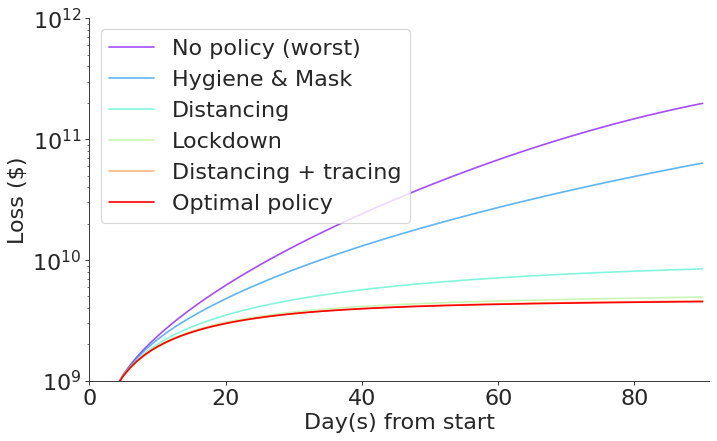

In [8]:
# Plot
figure(figsize=(10, 6), dpi=80)
legends = ['No policy (worst)', 'Hygiene & Mask', 'Distancing', 'Lockdown', 'Distancing + tracing', 'Optimal policy']
al = [0.7]*5+[1]
col = cm.rainbow(np.linspace(0, 1, 6))
plt.yscale('log')
for i,indice in enumerate(index):
  h1, h2, h3, d1, d2, d3, l1, l2, l3, q1, q2, q3 = indice
  hygiene_list = [h1/2]*30 + [h2/2]*30 + [h3/2]*30
  distancing_list = [d1/2]*30 + [d2/2]*30 + [d3/2]*30
  lockdown_list = [l1/2]*30 + [l2/2]*30 + [l3/2]*30
  quarantine_list = [q1/2]*30 + [q2/2]*30 + [q3/2]*30
  susc, exp, inf, rec, d, re, policy,cont_tracing = virus_model(hygiene_list, distancing_list,lockdown_list,quarantine_list)        
  point = evaluate(inf, rec, d, policy,cont_tracing)
  m = [m for m in range(91)]
  plt.plot(m, point, label=legends[i], alpha = al[i], color = col[i])
  plt.plot()

plt.legend(loc = 'upper left', fontsize = 20)
plt.ylim([10**9, 10**12])
plt.xlim([0, 91])
plt.xlabel('Day(s) from start', fontsize = 20)
plt.ylabel('Loss ($)', fontsize = 20)
sns.despine()
plt.rcParams["figure.figsize"] = (10, 10)
plt.tick_params(labelsize=20)
plt.savefig('./content/sample_data/loss.pdf')


### Make table

In [9]:
# Code abbreviations
res = []
keys = ['M', 'D', 'L', 'T']
for i,indice in enumerate(index):
  h1, h2, h3, d1, d2, d3, l1, l2, l3, q1, q2, q3 = indice
  hygiene_list = [h1/2]*30 + [h2/2]*30 + [h3/2]*30
  distancing_list = [d1/2]*30 + [d2/2]*30 + [d3/2]*30
  lockdown_list = [l1/2]*30 + [l2/2]*30 + [l3/2]*30
  quarantine_list = [q1/2]*30 + [q2/2]*30 + [q3/2]*30
  susc, exp, inf, rec, d, re, policy,cont_tracing = virus_model(hygiene_list, distancing_list,lockdown_list,quarantine_list)        
  point = evaluate(inf, rec, d, policy,cont_tracing)
  print(point)
  label = ''
  for i in [0, 3, 6, 9]:
    if indice[i] == 2:
      label += keys[i//3]
    if indice[i] == 1:
      label += keys[i//3].lower()
  if sum([indice[i] for i in [0, 3, 6, 9]]) == 0:
      label += '-'
  label += ' | '
  for i in [1, 4, 7, 10]:
    if indice[i] == 2:
      label += keys[i//3]
    if indice[i] == 1:
      label += keys[i//3].lower()
  if sum([indice[i] for i in [1, 4, 7, 10]]) == 0:
      label += '-'
  label += ' | '
  for i in [2, 5, 8, 11]:
    if indice[i] == 2:
      label += keys[i//3]
    if indice[i] == 1:
      label += keys[i//3].lower()
  if sum([indice[i] for i in [2, 5, 8, 11]]) == 0:
      label += '-'
  res.append([label, int(1000000-susc[-1]), int(d[-1]), point[-1]/1000000000])




[-0.0, 243048989.58971217, 470678582.1668743, 690577331.1735109, 908237760.8551673, 1127633311.3754811, 1351688723.9838376, 1582607088.6732883, 1822097374.9588842, 2074236122.0474293, 2342150151.2319617, 2627239907.0491276, 2930770376.0273614, 3253924474.7595596, 3597840495.176862, 3963638463.533936, 4352438784.206866, 4765375507.530481, 5203605843.889663, 5668317047.890548, 6160731449.867514, 6682110170.847734, 7233755889.18961, 7817014910.067934, 8433278707.264355, 9083985049.549042, 9770618783.818312, 10494712318.882685, 11257845833.772503, 12061647220.14198, 12907791758.07521, 13798001517.133377, 14734044469.007896, 15717733294.09704, 16750923861.323364, 17835513358.30278, 18973438047.40031, 20166670622.162304, 21417217138.044987, 22727113491.241478, 24098421419.742825, 25533224001.568817, 27033620626.39734, 28601721418.640667, 30239641092.40032, 31949492221.718967, 33733377913.174995, 35593383872.168655, 37531569859.25571, 39549960538.61687, 41650535727.21853, 43835220060.41985, 4

Table represents loss regarding applied policies. The most effective policy combination is listed at the top. The meaning of policy notatioin is as follows:

*   None: Doing nothing
*   Uppercase: full efficacy
*   Lowercase: half efficacy


*   L/l: Lockdown
*   T/t: Tracing with distancing
*   D/d: Distancing
*   M/m: Masks and Hygiene

*Example: L | l | D denotes the consecutive policy execution of full lockdown (1st month), half lockdown (2nd month) and full distancing (3rd month).*










In [10]:
df = pd.DataFrame(res, columns = ['Policy combination', 'Cases', 'Deaths', 'Loss'])
df = df.set_index('Policy combination')
df.sort_values(by='Loss')

,Cases,Deaths,Loss
Policy combination,,,
MT | T | T,10734,577,4.525967
T | T | T,11003,591,4.569165
L | L | L,11003,591,4.932606
D | D | D,22478,1138,8.436941
M | M | M,201929,8941,63.400395
- | - | -,592136,28018,197.926939


# More results

In [11]:
# For more results:
def k_largest_index_argsort(a, k):
    idx = np.argsort(a.ravel())[-k:]
    return np.column_stack(np.unravel_index(idx, a.shape))

def k_smallest_index_argsort(a, k):
    idx = np.argsort(a.ravel())[:k]
    return np.column_stack(np.unravel_index(idx, a.shape))

x = result
# Choose bottom k combinations
k = 5
idx = k_smallest_index_argsort(x, k)
index.extend(idx.tolist())

# Choose top n combinations
n = 5
idx = k_largest_index_argsort(x, n)
index.extend(idx.tolist())

In [12]:
res = []
keys = ['M', 'D', 'L', 'T']
for i,indice in enumerate(index):
  h1, h2, h3, d1, d2, d3, l1, l2, l3, q1, q2, q3 = indice
  hygiene_list = [h1/2]*30 + [h2/2]*30 + [h3/2]*30
  distancing_list = [d1/2]*30 + [d2/2]*30 + [d3/2]*30
  lockdown_list = [l1/2]*30 + [l2/2]*30 + [l3/2]*30
  quarantine_list = [q1/2]*30 + [q2/2]*30 + [q3/2]*30
  susc, exp, inf, rec, d, re, policy,cont_tracing = virus_model(hygiene_list, distancing_list,lockdown_list,quarantine_list)        
  point = evaluate(inf, rec, d, policy,cont_tracing)
  print(point)
  label = ''
  for i in [0, 3, 6, 9]:
    if indice[i] == 2:
      label += keys[i//3]
    if indice[i] == 1:
      label += keys[i//3].lower()
  if sum([indice[i] for i in [0, 3, 6, 9]]) == 0:
      label += '-'
  label += ' | '
  for i in [1, 4, 7, 10]:
    if indice[i] == 2:
      label += keys[i//3]
    if indice[i] == 1:
      label += keys[i//3].lower()
  if sum([indice[i] for i in [1, 4, 7, 10]]) == 0:
      label += '-'
  label += ' | '
  for i in [2, 5, 8, 11]:
    if indice[i] == 2:
      label += keys[i//3]
    if indice[i] == 1:
      label += keys[i//3].lower()
  if sum([indice[i] for i in [2, 5, 8, 11]]) == 0:
      label += '-'
  res.append([label, int(1000000-susc[-1]), int(d[-1]), point[-1]/1000000000])




[-0.0, 243048989.58971217, 470678582.1668743, 690577331.1735109, 908237760.8551673, 1127633311.3754811, 1351688723.9838376, 1582607088.6732883, 1822097374.9588842, 2074236122.0474293, 2342150151.2319617, 2627239907.0491276, 2930770376.0273614, 3253924474.7595596, 3597840495.176862, 3963638463.533936, 4352438784.206866, 4765375507.530481, 5203605843.889663, 5668317047.890548, 6160731449.867514, 6682110170.847734, 7233755889.18961, 7817014910.067934, 8433278707.264355, 9083985049.549042, 9770618783.818312, 10494712318.882685, 11257845833.772503, 12061647220.14198, 12907791758.07521, 13798001517.133377, 14734044469.007896, 15717733294.09704, 16750923861.323364, 17835513358.30278, 18973438047.40031, 20166670622.162304, 21417217138.044987, 22727113491.241478, 24098421419.742825, 25533224001.568817, 27033620626.39734, 28601721418.640667, 30239641092.40032, 31949492221.718967, 33733377913.174995, 35593383872.168655, 37531569859.25571, 39549960538.61687, 41650535727.21853, 43835220060.41985, 4

In [13]:
df = pd.DataFrame(res, columns = ['Policy combination', 'Cases', 'Deaths', 'Loss'])
df = df.set_index('Policy combination')
df.sort_values(by='Loss')

,Cases,Deaths,Loss
Policy combination,,,
MT | T | T,10734,577,4.525967
T | T | T,11003,591,4.569165
L | L | L,11003,591,4.932606
MDLT | MDLT | MDLT,10006,539,5.482550
D | D | D,22478,1138,8.436941
mt | Lt | Dl,26023,1378,10.463221
mt | Lt | Dlt,25736,1370,10.472406
mt | L | DlT,25887,1383,10.561816
m | L | DT,59338,3502,25.313706
